# ClickSense: Decoding Purchase Intent

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import datetime
import math

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# Dataprocessing Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Libraries for data modeling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Libraries for model evaluation
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

# Miscellaneous libraries
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%pylab inline

2024-04-12 19:45:14.178374: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Data Collection

In [2]:
# load data
data=pd.read_csv('online_shoppers_intention.csv')
X=data.copy()

## Data Exploration

In [3]:
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
# columns
data.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')

In [5]:
# data description
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [6]:
# shape
data.shape

(12330, 18)

In [7]:
# missing values in column wise
cols = data.columns[data.isnull().sum()!=0]
if data[cols].isnull().sum().empty:
    print('There are no missing values in data')
else:
    print('Missing data')

There are no missing values in data


In [8]:
# numerical, non-numerical and boolean columns
obj_cols = [cols for cols in data.columns if data[cols].dtype == 'object']
bool_cols = [cols for cols in data.columns if data[cols].dtype == 'bool']
num_cols = [cols for cols in data.columns if data[cols].dtype not in ['object','bool']]

print(f'Non-numerical columns:\n{obj_cols}')
print(f'\nBoolean columns:\n{bool_cols}')
print(f'\nNumerical columns:\n{num_cols}')

Non-numerical columns:
['Month', 'VisitorType']

Boolean columns:
['Weekend', 'Revenue']

Numerical columns:
['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']


In [9]:
# Numerical data summary
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,12330.0,2.315166,3.321784,0.0,0.000000,1.000000,4.000000,27.000000
Administrative_Duration,12330.0,80.818611,176.779107,0.0,0.000000,7.500000,93.256250,3398.750000
Informational,12330.0,0.503569,1.270156,0.0,0.000000,0.000000,0.000000,24.000000
Informational_Duration,12330.0,34.472398,140.749294,0.0,0.000000,0.000000,0.000000,2549.375000
ProductRelated,12330.0,31.731468,44.475503,0.0,7.000000,18.000000,38.000000,705.000000
ProductRelated_Duration,12330.0,1194.746220,1913.669288,0.0,184.137500,598.936905,1464.157214,63973.522230
BounceRates,12330.0,0.022191,0.048488,0.0,0.000000,0.003112,0.016813,0.200000
ExitRates,12330.0,0.043073,0.048597,0.0,0.014286,0.025156,0.050000,0.200000
PageValues,12330.0,5.889258,18.568437,0.0,0.000000,0.000000,0.000000,361.763742
SpecialDay,12330.0,0.061427,0.198917,0.0,0.000000,0.000000,0.000000,1.000000


In [10]:
print('Before Modification')
print(data['Month'].unique())
print()

print('After Modification')
data['Month'] = data['Month'].replace('June', 'Jun', regex=True)
print(data['Month'].unique())

Before Modification
['Feb' 'Mar' 'May' 'Oct' 'June' 'Jul' 'Aug' 'Nov' 'Sep' 'Dec']

After Modification
['Feb' 'Mar' 'May' 'Oct' 'Jun' 'Jul' 'Aug' 'Nov' 'Sep' 'Dec']


## Data Visualization

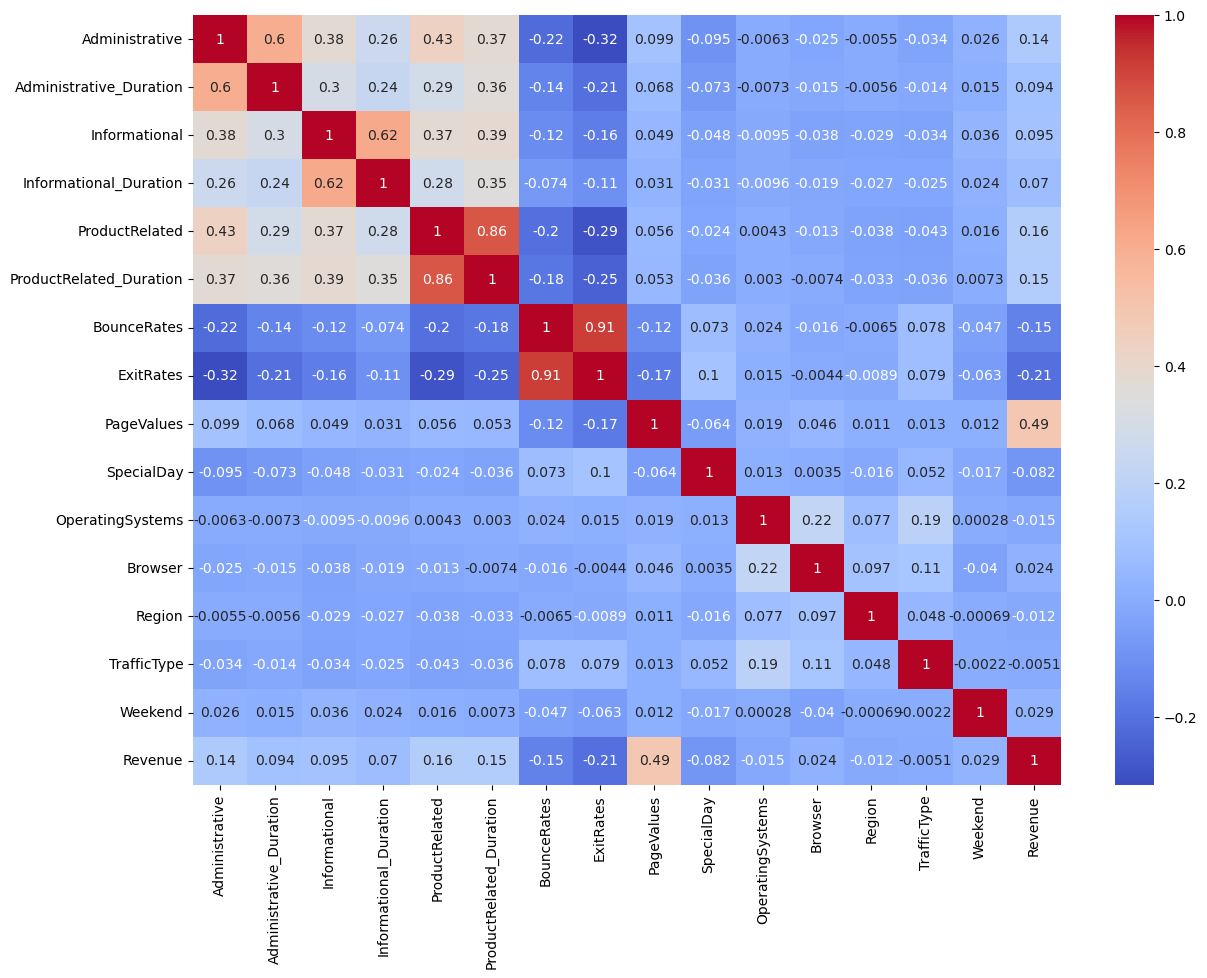

In [11]:
# heatmap (correlations among data)
corr=data.corr()
fig=plt.figure(figsize=(14,10))
sns.heatmap(corr, annot=True, cmap='coolwarm');

Text(0, 0.5, 'Percentage')

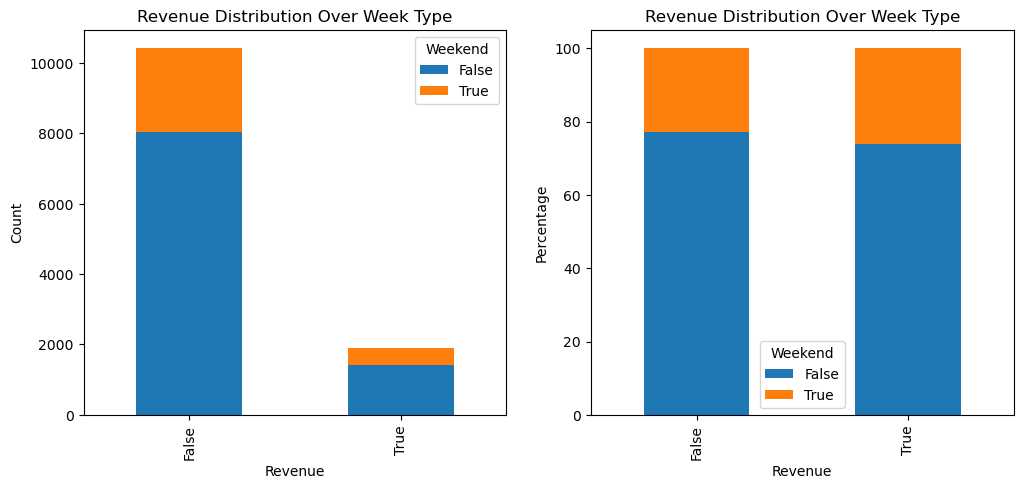

In [12]:
browser_users = data.groupby(['Revenue', 'Weekend']).size().unstack()
temp = browser_users.transpose() / browser_users.sum(axis=1) * 100
temp = temp.T

fig, axis = plt.subplots(1, 2, figsize=(12, 5))

browser_users.plot(kind='bar', stacked=True, ax=axis[0])
axis[0].set_title('Revenue Distribution Over Week Type')
axis[0].set_ylabel('Count')

temp.plot(kind='bar', stacked=True, ax=axis[1])
axis[1].set_title('Revenue Distribution Over Week Type')
axis[1].set_ylabel('Percentage')

Text(0, 0.5, 'Percentage')

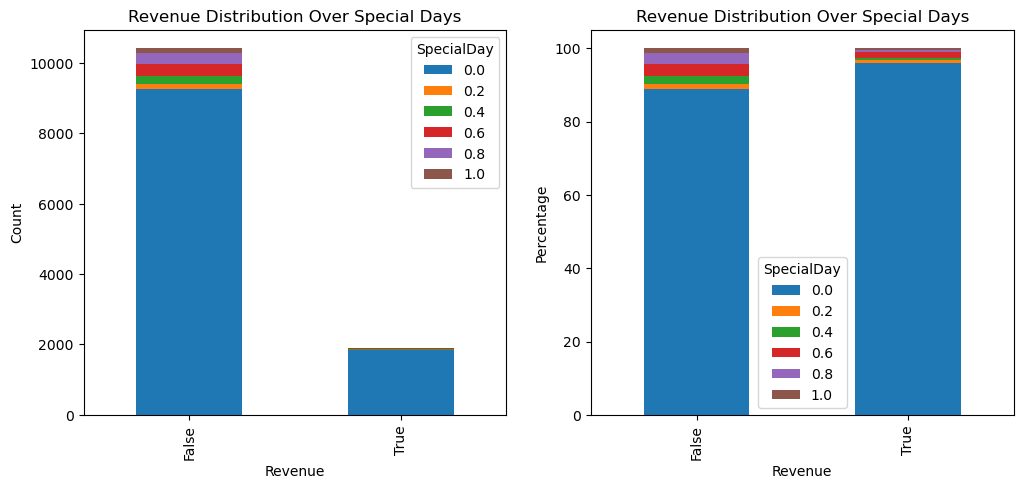

In [13]:
specialDay_users = data.groupby(['Revenue', 'SpecialDay']).size().unstack()
temp = specialDay_users.transpose() / specialDay_users.sum(axis=1) * 100
temp = temp.T

fig, axis = plt.subplots(1, 2, figsize=(12, 5))

specialDay_users.plot(kind='bar', stacked=True, ax=axis[0])
axis[0].set_title('Revenue Distribution Over Special Days')
axis[0].set_ylabel('Count')

temp.plot(kind='bar', stacked=True, ax=axis[1])
axis[1].set_title('Revenue Distribution Over Special Days')
axis[1].set_ylabel('Percentage')

In [14]:
data['month_nu'] = pd.to_datetime(data['Month'], format='%b').dt.month

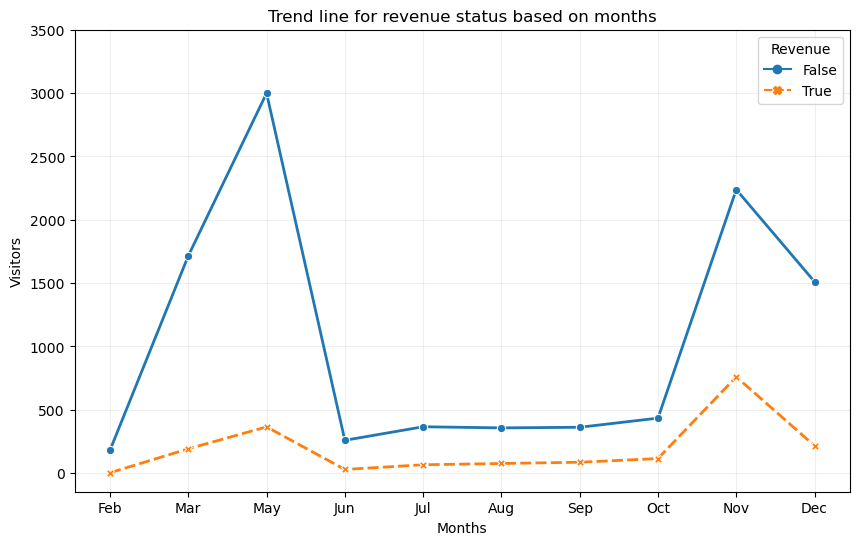

In [15]:
trend = pd.DataFrame(data.groupby(['Month', 'month_nu', 'Revenue']).size()).reset_index()
trend.sort_values('month_nu', inplace=True)
trend = trend.drop('month_nu', axis=1)
trend.columns = ["Months", "Revenue", "Frequency"]

plt.figure(figsize=(10, 6))
sns.lineplot(data=trend, x='Months', y='Frequency', hue='Revenue', style='Revenue', markers=True, markersize=6, linewidth=2)

plt.title("Trend line for revenue status based on months")
plt.xlabel("Months")
plt.ylabel("Visitors")
plt.yticks(range(0, 3501, 500))
plt.grid(alpha=0.2)

Text(0.5, 1.0, 'Top 5 OS Of Non Revenue Generating Users')

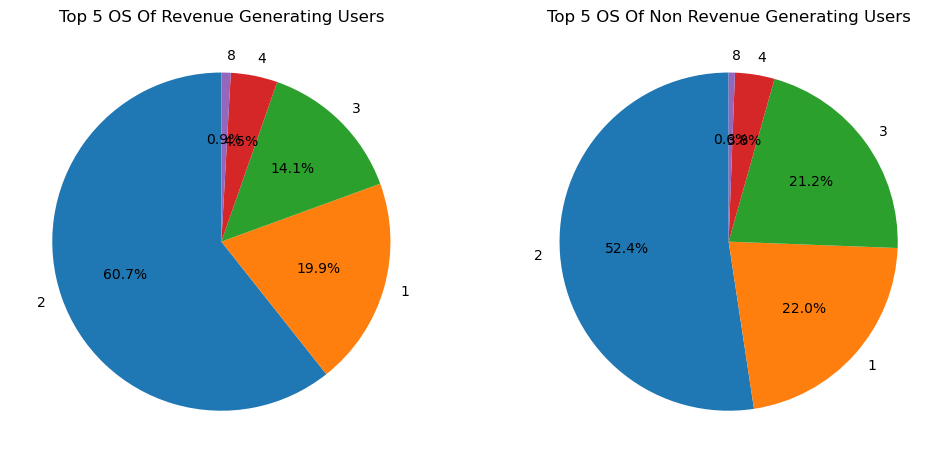

In [16]:
os_type_rev = data[data['Revenue'] == True]['OperatingSystems'].value_counts()
os_type_rev = os_type_rev[:5]

os_type_no_rev = data[data['Revenue'] == False]['OperatingSystems'].value_counts()
os_type_no_rev = os_type_no_rev[:5]


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(os_type_rev, labels=os_type_rev.index, autopct = '%.1f%%', startangle=90)
axes[0].set_title('Top 5 OS Of Revenue Generating Users')

axes[1].pie(os_type_no_rev, labels=os_type_rev.index, autopct = '%.1f%%', startangle=90)
axes[1].set_title('Top 5 OS Of Non Revenue Generating Users')

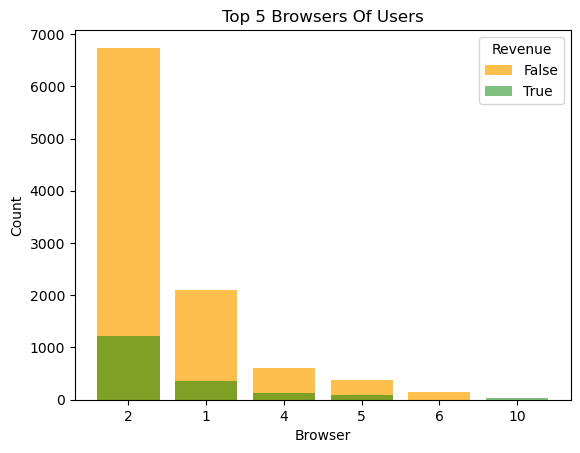

In [17]:
browser_rev = data[data['Revenue'] == True]['Browser'].value_counts()
browser_rev = browser_rev[:5]

browser_no_rev = data[data['Revenue'] == False]['Browser'].value_counts()
browser_no_rev = browser_no_rev[:5]

plt.bar(browser_no_rev.index.astype(str), browser_no_rev, label='False', color='orange', alpha=0.7)
plt.bar(browser_rev.index.astype(str), browser_rev, label='True', color='green', alpha=0.5)
plt.title('Top 5 Browsers Of Users')
plt.xlabel('Browser')
plt.ylabel('Count')
plt.legend(title='Revenue')

In [18]:
# log transform skewed variables
skew = data.skew()
skew = skew[abs(skew) > 0.75].index.tolist()

for i in skew:
    if data[i].min() < 0:
        data[i] = data[i] - data[i].min()
    data[i] = data[i].apply(np.log1p)

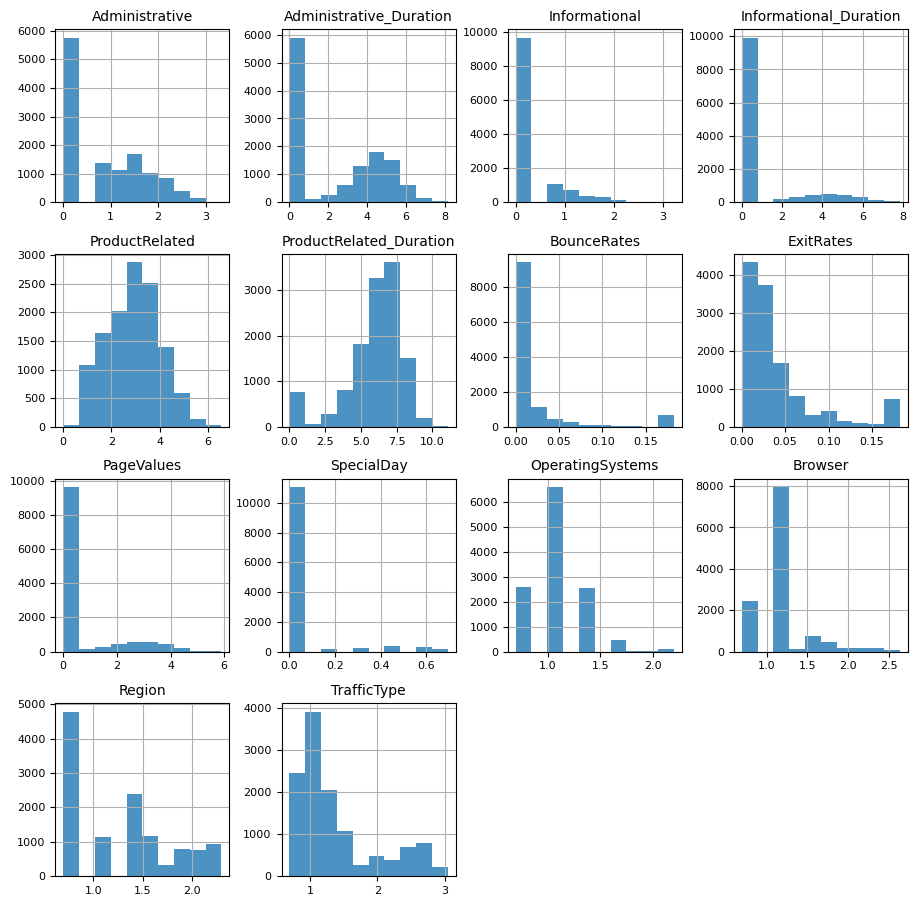

In [19]:
# histplot of numerical variables 
params = {'axes.titlesize':'10',
         'xtick.labelsize':'8',
         'ytick.labelsize':'8'}
matplotlib.rcParams.update(params)
data[num_cols].hist(figsize=(11,11), alpha=0.8);

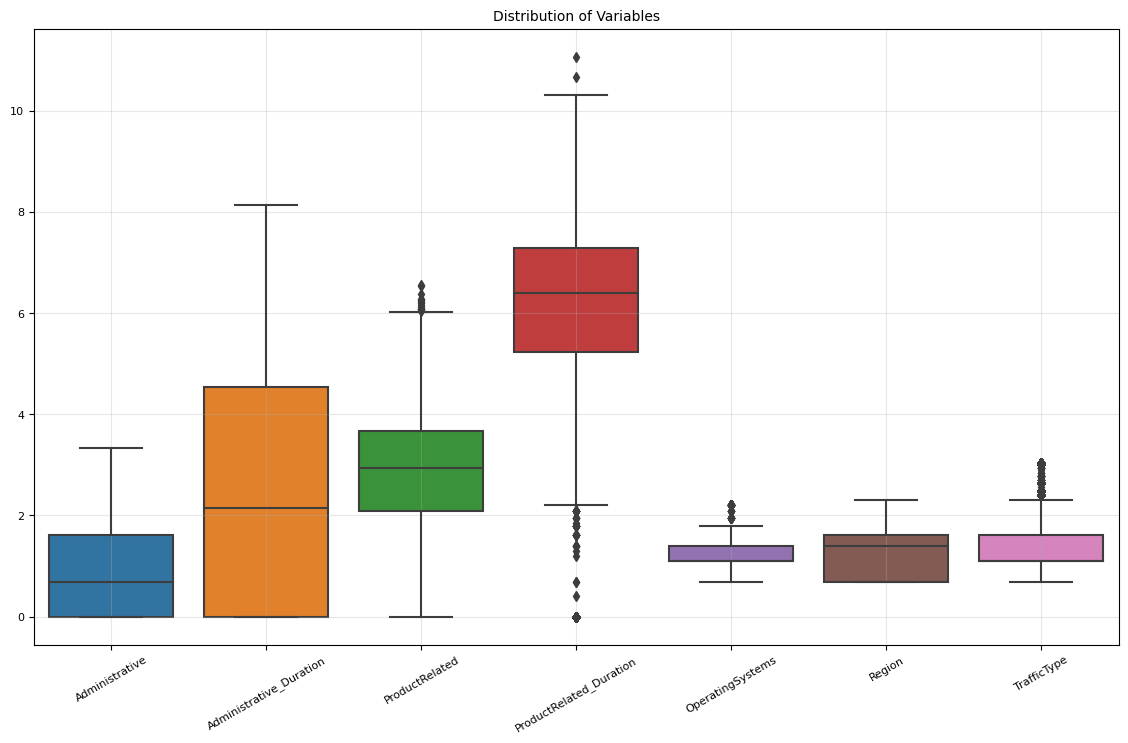

In [20]:
# boxplot of numerical variables
cols = data[['Administrative', 'Administrative_Duration','ProductRelated','ProductRelated_Duration',
            'OperatingSystems','Region', 'TrafficType']]
plt.figure(figsize=(14,8))
fig = sns.boxplot(data=cols)
fig.set_xticklabels(fig.get_xticklabels(),rotation=30)

plt.title('Distribution of Variables')
plt.grid(alpha=0.3)
plt.show()

## Data Processing

In [21]:
# Feature extraction
# Principal Component Analysis
flag=False

if flag:
    X = X[num_cols]

    # data standardization
    norm_x = (X - X.mean(axis=0))/X.std(axis=0)

    n = norm_x.shape[0]
    x_mean = np.mean(norm_x,axis=0)
    x_cov = np.cov(norm_x.astype(float).T, rowvar=False)

    eigen_val,eigen_vec = np.linalg.eig(x_cov)        # eigen value, eigen vector

    sort_x = np.argsort(eigen_val)[::-1]
    eigen_vectors = eigen_vec[:,sort_x]

    k=2
    pca_score = np.matmul(norm_x,eigen_vectors[:,:k])

    Proportion_var = []
    for i in eigen_val:
        Proportion_var.append((i/sum(eigen_val))*100)
    print(Proportion_var[:8])

    print(f'\nThe first {k} principal component scores:\n{pca_score}')

 Explained variance :
 [3.40863827 1.68573445 1.40023415 1.07815038 1.01007678 0.96804458
 0.9500514  0.91446478 0.85872358 0.75362047 0.4214237  0.35163483
 0.12284964 0.07748853]
 Proportion Variance :
 [0.24345442 0.12039984 0.10000861 0.0770045  0.07214249 0.06914043
 0.06785531 0.06531362 0.06133242 0.05382567 0.03009925 0.02511474
 0.00877426 0.00553445]
Cumulative proportion :
 [0.24345442 0.36385425 0.46386287 0.54086736 0.61300985 0.68215029
 0.7500056  0.81531921 0.87665164 0.9304773  0.96057655 0.98569129
 0.99446555 1.        ]


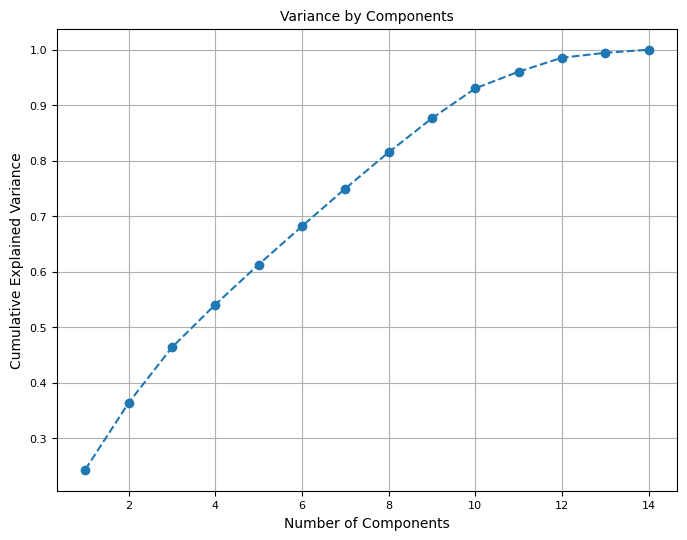

In [22]:
# Fitting the scaler to the data 'X' and transforming 'X' to standardize the features
X = X[num_cols]

scaler = StandardScaler()
X_standard = scaler.fit_transform(X)
 
pca = PCA()
 
# PCA model and transform it to get the principal components
pca_scores_4 = pd.DataFrame(pca.fit_transform(X_standard))
 
# the explained variance of each principal component
explained_var  = pca.explained_variance_
print(f" Explained variance :\n {explained_var}")
 
# the proportion of variance explained by each principal component
proportion_var = pca.explained_variance_ratio_
print(f" Proportion Variance :\n {proportion_var}")
 
# the cumulative proportion of variance
cummulative_proportion_var = np.cumsum(proportion_var)
print(f"Cumulative proportion :\n {cummulative_proportion_var}")
 
# Plotting Explained Variance by Components and number of components
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
 
plt.title('Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

The above figure indicates that retaining all features is essential for maximizing variance in the dataset. It underscores the importance of preserving the entirety of the original feature set to capture the maximum amount of variability present in the data. By maintaining all features, we ensure that no potentially valuable information is lost during the dimensionality reduction process.

### Getting Data Ready For Training

In [23]:
# load data
data=pd.read_csv('online_shoppers_intention.csv')

In [24]:
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [25]:
data.Weekend = data.Weekend.map(lambda x: 0 if x is False else 1)
data.Revenue = data.Revenue.map(lambda x: 0 if x is False else 1)

In [26]:
data.Month.unique()

array(['Feb', 'Mar', 'May', 'Oct', 'June', 'Jul', 'Aug', 'Nov', 'Sep',
       'Dec'], dtype=object)

In [27]:
months = {
    'Feb': 2,
    'Mar': 3,
    'May': 5,
    'June': 6,
    'Jul': 7,
    'Aug': 8,
    'Sep': 9,
    'Oct': 10,
    'Nov': 11,
    'Dec': 12
}

data['Month'] = data['Month'].map(months)

In [28]:
data.VisitorType.value_counts()

Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64

In [29]:
# create columns for categorical values of column Visitortype
x1 = pd.get_dummies(data.VisitorType)
data = pd.concat([data,x1],axis=1)

In [30]:
# drop redundant columns 
data.drop(['VisitorType','Other'],axis=1,inplace=True)

In [31]:
data = data[['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend',
       'New_Visitor', 'Returning_Visitor','Revenue']]

In [32]:
# Data Standardization
Scaler = StandardScaler()
scaled_x = Scaler.fit_transform(data.drop(columns=['Revenue']))

In [33]:
data1 = pd.DataFrame(scaled_x,columns=data.columns[:-1])
data1.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,Weekend,New_Visitor,Returning_Visitor
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,-1.665924,-1.233426,-0.790293,-0.894178,-0.762629,-0.550552,-0.399087,0.410621
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.457683,1.171473,-0.317178,-0.308821,-1.665924,-0.136078,-0.207952,-0.894178,-0.514182,-0.550552,-0.399087,0.410621
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,-1.665924,2.058618,-0.790293,2.437081,-0.265735,-0.550552,-0.399087,0.410621
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0.573535,1.994610,-0.317178,-0.308821,-1.665924,0.961270,-0.207952,-0.477771,-0.017289,-0.550552,-0.399087,0.410621
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,-0.045196,0.142551,-0.317178,-0.308821,-1.665924,0.961270,0.374389,-0.894178,-0.017289,1.816360,-0.399087,0.410621


In [34]:
# assigning predictor variables and target into x and y
X = data1
y = data[['Revenue']]

#### Here we have imbalanced dataset, so performed oversampling

In [35]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

In [36]:
# Perform oversampling
X_resampled, y_resampled = smote.fit_resample(X, y)

In [37]:
# split data into train test validation set
X_train,X_temp,y_train,y_temp = train_test_split(X_resampled,y_resampled,test_size=0.22,random_state=42)
X_val,X_test,y_val,y_test = train_test_split(X_temp,y_temp,test_size=0.5,random_state=42)

In [38]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (16258, 18)
X_val shape: (2293, 18)
X_test shape: (2293, 18)
y_train shape: (16258, 1)
y_val shape: (2293, 1)
y_test shape: (2293, 1)


## Model Performace Evaluation and Interpretation

we will choose the best model among 5 Models based on the performance metrics. 
1) Logistic Regression
2) K-Nearest Neighbors
3) Decision Tree
4) Support vector machine
5) Neural network (MLP)

### Logistic Regression

In [39]:
model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

In [40]:
y_pred = model.predict(X_val)
Lr_accuracy = accuracy_score(y_val,y_pred)
print(f'The Accuracy of the model using Logistic Regression is: {round(Lr_accuracy,3)}')

The Accuracy of the model using Logistic Regression is: 0.825


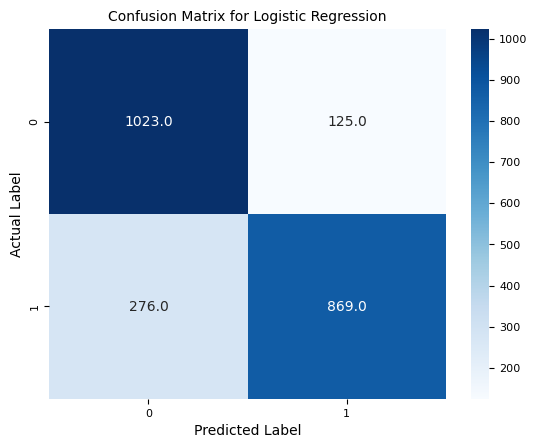

In [41]:
cm = confusion_matrix(y_val, y_pred)

sns.heatmap(cm, annot=True, fmt='.1f', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label');

In [42]:
classification = classification_report(y_val,y_pred)
print(f'The Classification report of the model using Logistic Regression is:\n {classification}')

The Classification report of the model using Logistic Regression is:
               precision    recall  f1-score   support

           0       0.79      0.89      0.84      1148
           1       0.87      0.76      0.81      1145

    accuracy                           0.83      2293
   macro avg       0.83      0.83      0.82      2293
weighted avg       0.83      0.83      0.82      2293



(0.0, 1.1)

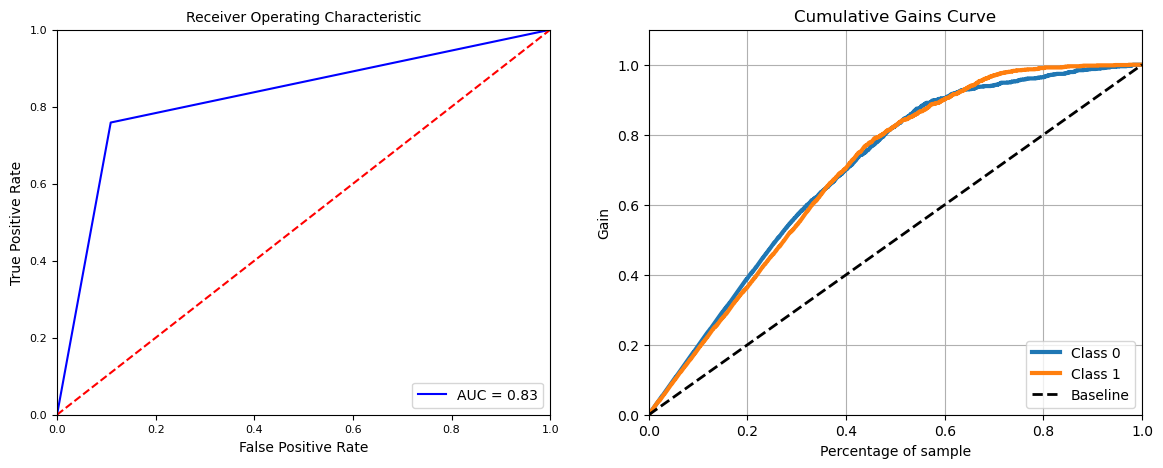

In [43]:
# Calculating ROC 
fpr, tpr, threshold = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=False)
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_title('Receiver Operating Characteristic')
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')
ax1.legend(loc = 'lower right')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
 
skplt.metrics.plot_cumulative_gain(y_val,model.predict_proba(X_val), ax=ax2)
ax2.set_ylim([0, 1.1])

### K-Nearest Neighbours (KNN)

Using KNN with Manhattan Distance

Testing for 1 neighbour..
The Accuracy for 1 neighbours is: 0.93

Testing for 2 neighbour..
The Accuracy for 2 neighbours is: 0.93

Testing for 3 neighbour..
The Accuracy for 3 neighbours is: 0.91

Testing for 4 neighbour..
The Accuracy for 4 neighbours is: 0.91

Testing for 5 neighbour..
The Accuracy for 5 neighbours is: 0.9



Text(0, 0.5, 'Accuracy')

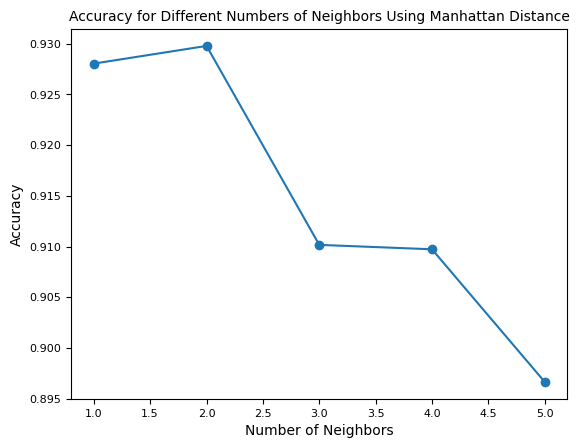

In [44]:
knn_acc = []

for k in range(1,6):
    print(f'Testing for {k} neighbour..')
    model = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
    
    # Accuracy
    accuracy = accuracy_score(y_val,y_pred)
    knn_acc.append(accuracy)
    print(f'The Accuracy for {k} neighbours is: {round(accuracy,2)}\n')

plt.plot(range(1, len(knn_acc) + 1), knn_acc, marker='o')
plt.title('Accuracy for Different Numbers of Neighbors Using Manhattan Distance')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')

Using KNN with Euclidean Distance

Testing for 1 neighbour..
The Accuracy for 1 neighbours is: 0.91

Testing for 2 neighbour..
The Accuracy for 2 neighbours is: 0.92

Testing for 3 neighbour..
The Accuracy for 3 neighbours is: 0.89

Testing for 4 neighbour..
The Accuracy for 4 neighbours is: 0.89

Testing for 5 neighbour..
The Accuracy for 5 neighbours is: 0.87



Text(0, 0.5, 'Accuracy')

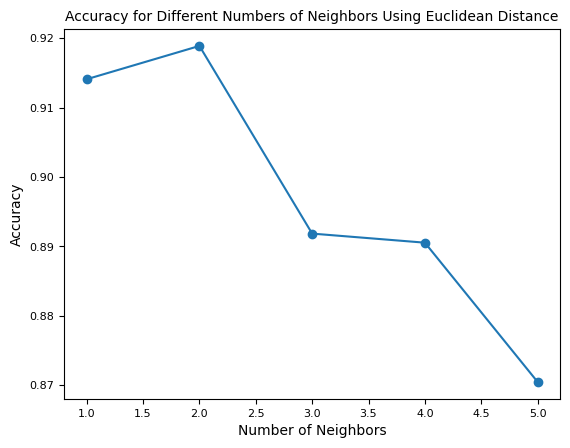

In [45]:
knn_acc = []

for k in range(1,6):
    print(f'Testing for {k} neighbour..')
    model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
    
    # Accuracy
    accuracy = accuracy_score(y_val,y_pred)
    knn_acc.append(accuracy)
    print(f'The Accuracy for {k} neighbours is: {round(accuracy,2)}\n')

plt.plot(range(1, len(knn_acc) + 1), knn_acc, marker='o')
plt.title('Accuracy for Different Numbers of Neighbors Using Euclidean Distance')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')

Based on the preceding analysis, it becomes evident that the KNN model yields optimal outcomes when configured with a neighbor count of 2 and employing Manhattan distance for distance calculation.

In [46]:
model = KNeighborsClassifier(n_neighbors=2, metric='manhattan')
model.fit(X_train,y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=2)

In [47]:
y_pred = model.predict(X_val)
Knn_accuracy = accuracy_score(y_val,y_pred)
print(f'The Accuracy of the model using K-Nearest Neighbor is: {round(Knn_accuracy,3)}')

The Accuracy of the model using K-Nearest Neighbor is: 0.93


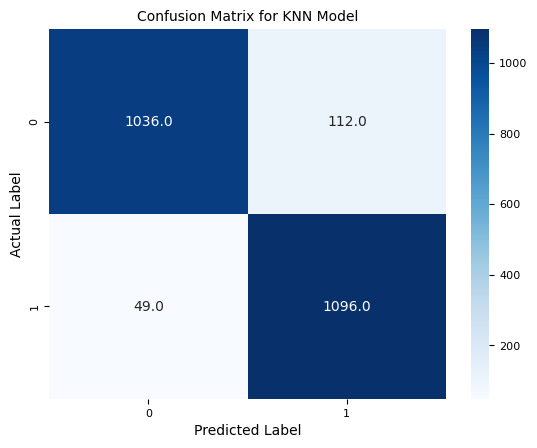

In [48]:
cm = confusion_matrix(y_val, y_pred)

sns.heatmap(cm, annot=True, fmt='.1f', cmap='Blues')
plt.title('Confusion Matrix for KNN Model')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label');

In [49]:
classification = classification_report(y_val,y_pred)
print(f'The Classification report of the model using K-Nearest Neighbor is:\n {classification}')

The Classification report of the model using K-Nearest Neighbor is:
               precision    recall  f1-score   support

           0       0.95      0.90      0.93      1148
           1       0.91      0.96      0.93      1145

    accuracy                           0.93      2293
   macro avg       0.93      0.93      0.93      2293
weighted avg       0.93      0.93      0.93      2293



(0.0, 1.1)

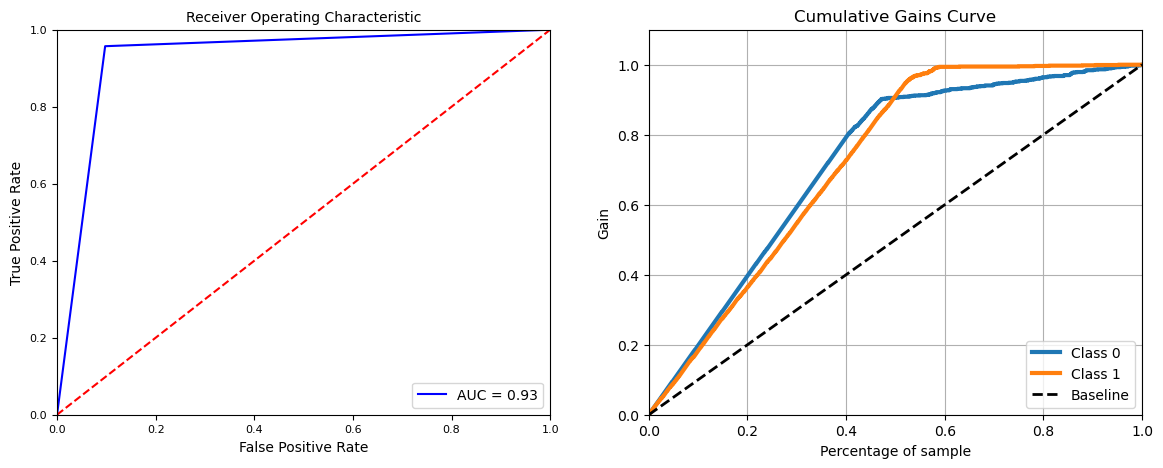

In [50]:
# Calculating ROC 
fpr, tpr, threshold = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=False)
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_title('Receiver Operating Characteristic')
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')
ax1.legend(loc = 'lower right')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
 
skplt.metrics.plot_cumulative_gain(y_val,model.predict_proba(X_val), ax=ax2)
ax2.set_ylim([0, 1.1])

### Decision Tree

In [51]:
model = DecisionTreeClassifier()
model.fit(X_train,y_train)

DecisionTreeClassifier()

In [52]:
y_pred = model.predict(X_val)
Dt_accuracy = accuracy_score(y_val,y_pred)
print(f'The Accuracy of the model using Decision Tree is: {round(Dt_accuracy,3)}')

The Accuracy of the model using Decision Tree is: 0.905


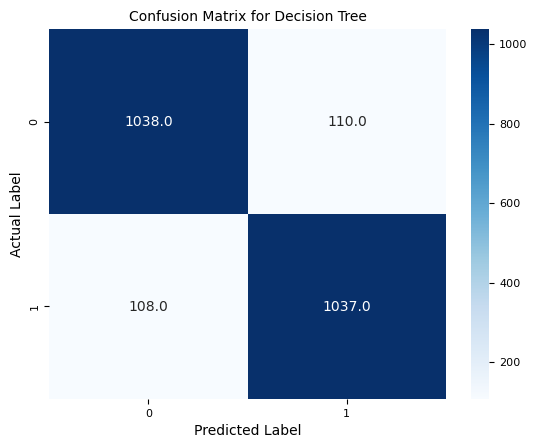

In [53]:
cm = confusion_matrix(y_val, y_pred)

sns.heatmap(cm, annot=True, fmt='.1f', cmap='Blues')
plt.title('Confusion Matrix for Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label');

In [54]:
classification = classification_report(y_val,y_pred)
print(f'The Classification report of the model using Decision Tree is:\n {classification}')

The Classification report of the model using Decision Tree is:
               precision    recall  f1-score   support

           0       0.91      0.90      0.90      1148
           1       0.90      0.91      0.90      1145

    accuracy                           0.90      2293
   macro avg       0.90      0.90      0.90      2293
weighted avg       0.90      0.90      0.90      2293



(0.0, 1.1)

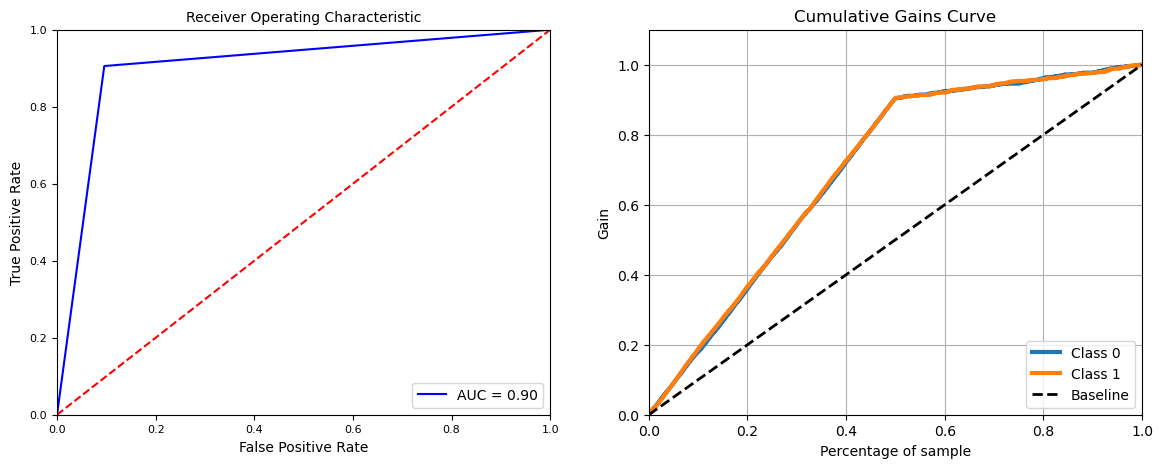

In [55]:
# Calculating ROC 
fpr, tpr, threshold = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=False)
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_title('Receiver Operating Characteristic')
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')
ax1.legend(loc = 'lower right')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
 
skplt.metrics.plot_cumulative_gain(y_val,model.predict_proba(X_val), ax=ax2)
ax2.set_ylim([0, 1.1])

### Support Vector Machine 

In [56]:
model = SVC(probability=True)
model.fit(X_train,y_train)

SVC(probability=True)

In [57]:
y_pred = model.predict(X_val)
SVC_accuracy = accuracy_score(y_val,y_pred)
print(f'The Accuracy of the model using Support Vector Machine is: {round(SVC_accuracy,3)}')

The Accuracy of the model using Support Vector Machine is: 0.863


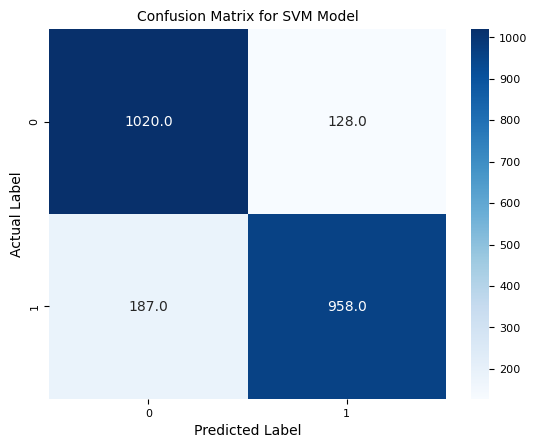

In [58]:
cm = confusion_matrix(y_val, y_pred)

sns.heatmap(cm, annot=True, fmt='.1f', cmap='Blues')
plt.title('Confusion Matrix for SVM Model')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label');

In [59]:
classification = classification_report(y_val,y_pred)
print(f'The Classification report of the model using Support Vector Machine is:\n {classification}')

The Classification report of the model using Support Vector Machine is:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1148
           1       0.88      0.84      0.86      1145

    accuracy                           0.86      2293
   macro avg       0.86      0.86      0.86      2293
weighted avg       0.86      0.86      0.86      2293



(0.0, 1.1)

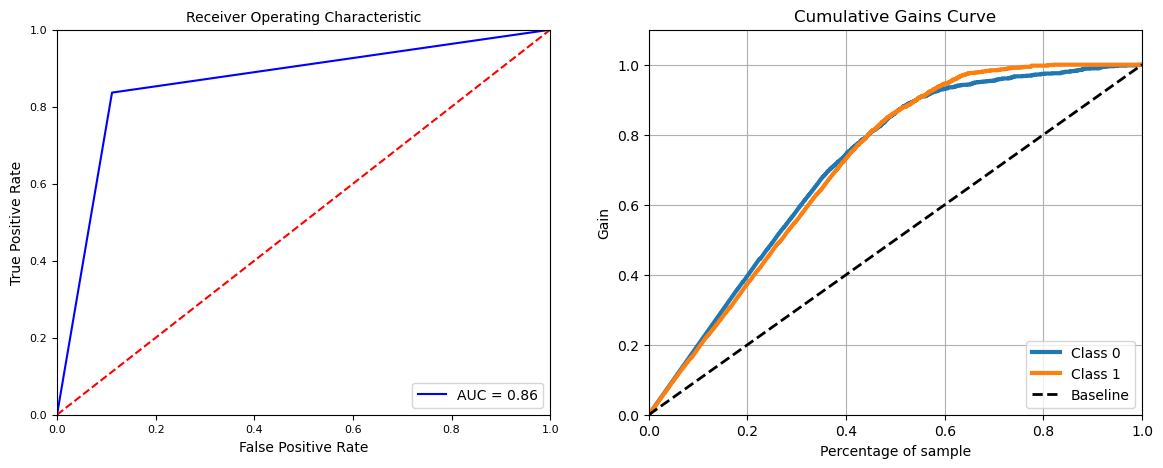

In [60]:
# Calculating ROC 
fpr, tpr, threshold = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=False)
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_title('Receiver Operating Characteristic')
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')
ax1.legend(loc = 'lower right')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
 
skplt.metrics.plot_cumulative_gain(y_val,model.predict_proba(X_val), ax=ax2)
ax2.set_ylim([0, 1.1])

### Neural Networks

In [61]:
model = keras.Sequential([
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(1,activation='sigmoid')
])

In [62]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [63]:
model.fit(X_train,y_train,epochs=12,batch_size=32,verbose=1);

Epoch 1/12
509/509 [==============================] - 3s 3ms/step - loss: 0.4203 - accuracy: 0.8066
Epoch 2/12
509/509 [==============================] - 1s 2ms/step - loss: 0.3397 - accuracy: 0.8554
Epoch 3/12
509/509 [==============================] - 1s 2ms/step - loss: 0.3171 - accuracy: 0.8646
Epoch 4/12
509/509 [==============================] - 1s 2ms/step - loss: 0.3018 - accuracy: 0.8736
Epoch 5/12
509/509 [==============================] - 1s 2ms/step - loss: 0.2933 - accuracy: 0.8764
Epoch 6/12
509/509 [==============================] - 1s 2ms/step - loss: 0.2840 - accuracy: 0.8811
Epoch 7/12
509/509 [==============================] - 1s 2ms/step - loss: 0.2750 - accuracy: 0.8846
Epoch 8/12
509/509 [==============================] - 1s 2ms/step - loss: 0.2694 - accuracy: 0.8874
Epoch 9/12
509/509 [==============================] - 1s 2ms/step - loss: 0.2651 - accuracy: 0.8880
Epoch 10/12
509/509 [==============================] - 1s 2ms/step - loss: 0.2588 - accuracy: 0.8925

In [64]:
y_pred = model.predict(X_val)
y_pred = np.round(y_pred).flatten()

72/72 [==============================] - 0s 2ms/step


In [65]:
NN_accuracy = accuracy_score(y_val,y_pred)
print(f'The Accuracy of the model using MultiLayer Perceptron is: {round(NN_accuracy,3)}')

The Accuracy of the model using MultiLayer Perceptron is: 0.885


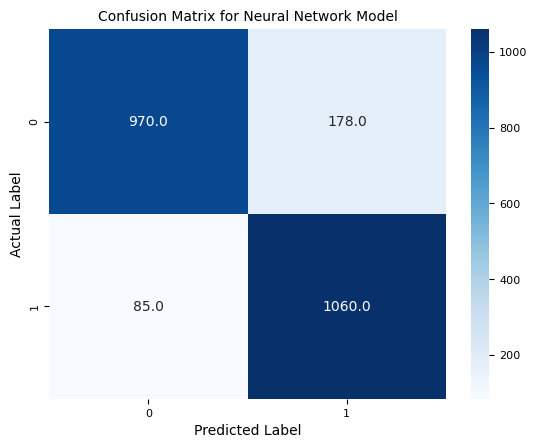

In [66]:
cm = confusion_matrix(y_val, y_pred)

sns.heatmap(cm, annot=True, fmt='.1f', cmap='Blues')
plt.title('Confusion Matrix for Neural Network Model')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label');

In [67]:
classification = classification_report(y_val,y_pred)
print(f'The Classification report of the model using MultiLayer Perceptron is:\n {classification}')

The Classification report of the model using MultiLayer Perceptron is:
               precision    recall  f1-score   support

           0       0.92      0.84      0.88      1148
           1       0.86      0.93      0.89      1145

    accuracy                           0.89      2293
   macro avg       0.89      0.89      0.89      2293
weighted avg       0.89      0.89      0.89      2293



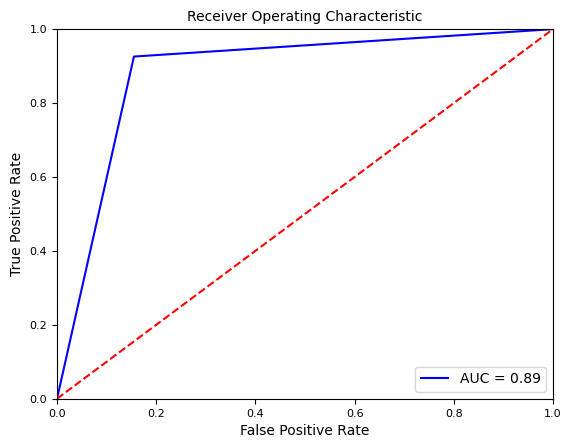

In [68]:
# Plotting ROC
fpr, tpr, threshold = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
 
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Comparing Model Performance

In [69]:
accuracies = {'Logistic Regression':Lr_accuracy,
              'K-Nearest Neighbor':Knn_accuracy,
              'Decision Tree':Dt_accuracy,
              'Support Vector Machine':SVC_accuracy,
              'Neural Networks':NN_accuracy}

model_accuracy = pd.DataFrame.from_dict(accuracies,orient='index')
model_accuracy.index.name = 'Model'
model_accuracy.rename(columns={model_accuracy.columns[0]:'Accuracy'})

,Accuracy
Model,
Logistic Regression,0.825120
K-Nearest Neighbor,0.929786
Decision Tree,0.904928
Support Vector Machine,0.862625
Neural Networks,0.885303


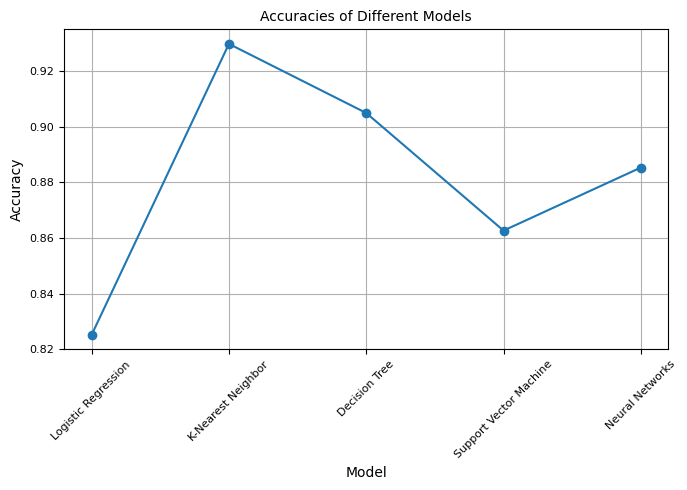

In [70]:
# Plotting the line chart
plt.figure(figsize=(7, 5))
plt.plot(model_accuracy.index, model_accuracy.values, marker='o', linestyle='-')
plt.title('Accuracies of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Testing Optimal Model : K-Nearest Neighbors

#### Model testing on the test data using the model that achieved the highest accuracy during validation.

In [71]:
for k in range(1,6):
    print(f'Testing for {k} neighbour..')
    model = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    # Accuracy
    accuracy = accuracy_score(y_test,y_pred)
    print(f'The Accuracy for {k} neighbours is: {round(accuracy,2)}\n')

Testing for 1 neighbour..
The Accuracy for 1 neighbours is: 0.94

Testing for 2 neighbour..
The Accuracy for 2 neighbours is: 0.94

Testing for 3 neighbour..
The Accuracy for 3 neighbours is: 0.92

Testing for 4 neighbour..
The Accuracy for 4 neighbours is: 0.93

Testing for 5 neighbour..
The Accuracy for 5 neighbours is: 0.91



In [72]:
model = KNeighborsClassifier(n_neighbors=2, metric='manhattan')
model.fit(X_train,y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=2)

In [73]:
y_pred = model.predict(X_test)
Knn_accuracy = accuracy_score(y_test,y_pred)
print(f'The Accuracy of the model using K-Nearest Neighbor is: {round(Knn_accuracy,3)}')

The Accuracy of the model using K-Nearest Neighbor is: 0.939


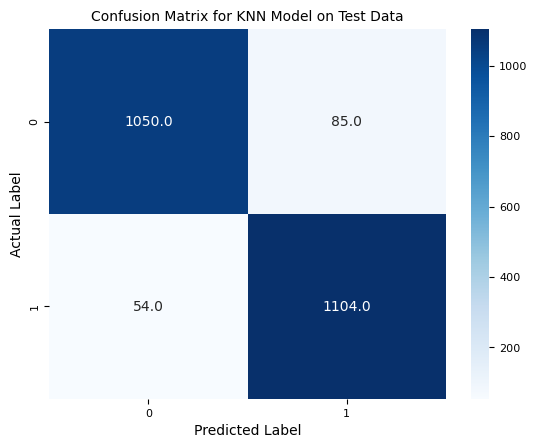

In [74]:
# Plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='.1f', cmap='Blues')
plt.title('Confusion Matrix for KNN Model on Test Data')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label');

In [75]:
classification = classification_report(y_test,y_pred)
print(f'The Classification report of the model using K-Nearest Neighbor is:\n {classification}')

The Classification report of the model using K-Nearest Neighbor is:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      1135
           1       0.93      0.95      0.94      1158

    accuracy                           0.94      2293
   macro avg       0.94      0.94      0.94      2293
weighted avg       0.94      0.94      0.94      2293

